In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0      c8a40715-5a18-4b2c-9a4d-509071b2767b
1      b90c7214-e4ce-44c9-b6f1-091deab6109a
2      3423ef5c-3556-4c76-ba99-e8de32529b17
3      5ea9ab41-4789-4586-8df4-69f3fec8f1d7
4      d077d512-d8a7-4a6d-8fb7-5df2da85e250
                       ...                 
151    81e89063-a785-46b9-9801-7a8eb2ca7fb4
152    af73858a-bda1-4422-a105-a8552dc97604
153    e05569da-2671-4d07-aa91-376acd518d06
154    4f96453a-5e58-4aa3-9be0-15acc0f10bd0
155    22ba6bf1-3bde-4735-8f1a-49cb6e081d37
Length: 156, dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("af73")]

152    af73858a-bda1-4422-a105-a8552dc97604
dtype: object

In [5]:
target_eid = df_base["eid"].unique()[152]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['af73858a-bda1-4422-a105-a8552dc97604'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
    o_ctv = pd.DataFrame(np.vstack(df_base["o.ct_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_v.x", "o.ct_v.y"])
    o_ctcloc = pd.DataFrame(np.vstack(df_base["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_cloc.x", "o.ct_cloc.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
    o_ctv = pd.DataFrame({"o.ct_v": empty_array, "o.ct_v.x": empty_array, "o.ct_v.y": empty_array})
    o_ctcloc = pd.DataFrame({"o.ct_cloc": empty_array, "o.ct_cloc.x": empty_array, "o.ct_cloc.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctcloc, o_ctdv, o_ctv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    df["o.ct_ct"] = empty_array
    df["o.ct_cradius"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o.ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_cloc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o.t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o.t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
#df["o.ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
#df["o.ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_loc.y,o.t_v.x,o.t_v.y,angle.x,angle.y,speed,o.ct_dist,o.t_dist,o.t_speed,f_mag
0,12869,af73858a-bda1-4422-a105-a8552dc97604,0.000000,"[31829.47075972064, 107545.31626957547]",0.954248,"[19.452983632731556, 27.511744870750977]",-0.065198,"[-4811.924068311385, 1358.450131880301]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,110026.198364,-992.134402,125.177191,57.822218,81.587935,33.694431,791.495358,19818.962881,1000.000000,5000.0
1,12870,af73858a-bda1-4422-a105-a8552dc97604,0.016667,"[31829.794976114517, 107545.77479865665]",0.953162,"[19.412884265495627, 27.523065288516648]",-0.048532,"[-4811.885805285409, 1358.5856604913765]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,110026.198364,-992.137531,125.152386,57.910841,81.525055,33.680546,790.945200,19819.227156,1000.000000,5000.0
2,12871,af73858a-bda1-4422-a105-a8552dc97604,0.033333,"[31830.118524185607, 107546.23351641146]",0.952353,"[19.37278521711825, 27.53438683568741]",-0.031865,"[-4811.846244558935, 1358.7257702436036]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,110026.198364,-992.140660,125.127577,57.976764,81.478186,33.666709,790.395416,19819.490757,1000.000000,5000.0
3,12872,af73858a-bda1-4422-a105-a8552dc97604,0.050000,"[31830.441403939225, 107546.69242285873]",0.951822,"[19.33268649841359, 27.54570955043944]",-0.015198,"[-4811.805379973926, 1358.870481412403]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,110026.198364,-992.143789,125.102763,58.020028,81.447384,33.652918,789.846008,19819.753684,1000.000000,5000.0
4,12873,af73858a-bda1-4422-a105-a8552dc97604,0.066667,"[31830.763615380863, 107547.1515180179]",0.951568,"[19.292588120247142, 27.557033471117876]",0.001468,"[-4811.763205330135, 1359.0198143629368]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,110026.198364,-992.146918,125.077944,58.040657,81.432685,33.639174,789.296974,19820.015936,1000.000000,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,14278,af73858a-bda1-4422-a105-a8552dc97604,23.483333,"[21784.469779270115, 109205.47575760983]",5.952480,"[-771.239550474789, 65.81086200915952]",-0.149441,"[4981.895241032781, -425.1115234558217]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,110026.198364,-765.935069,65.358224,94.581357,-32.471015,774.042320,NaN,9653.027045,768.718562,5000.0
1410,14279,af73858a-bda1-4422-a105-a8552dc97604,23.500000,"[21771.615786762202, 109206.57260531]",5.949989,"[-771.1980346811138, 65.80731941313073]",-0.132775,"[4981.89524103271, -425.1115234566447]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,110026.198364,-768.145834,65.546871,94.500189,-32.706487,774.000654,NaN,9640.126340,770.937361,5000.0
1411,14280,af73858a-bda1-4422-a105-a8552dc97604,23.516667,"[21758.762486184183, 109207.66939396688]",5.947776,"[-771.1565188874386, 65.80377681710192]",-0.116108,"[4981.895241032607, -425.1115234578571]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,110026.198364,-770.369171,65.736591,94.427581,-32.915528,773.958987,NaN,9627.226329,773.168778,5000.0
1412,14281,af73858a-bda1-4422-a105-a8552dc97604,23.533333,"[21745.909877536058, 109208.7661235805]",5.945841,"[-771.1150030937633, 65.8002342210731]",-0.099441,"[-4981.895241032954, 425.11152345379674]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,110026.198364,-772.605147,65.927390,94.363708,-33.098196,773.917320,NaN,9614.327012,775.412880,5000.0


In [10]:
df.iloc[-1]["o"]

{'o': 'stellarpunk.orders.GoToLocation',
 'nnd': inf,
 't_loc': [12166.395879920085, 110026.19836421676],
 't_v': [-767.5600619148329, 65.49688652160224],
 'cs': False}

# Basic Ship Vitals

## Position and Heading

In [11]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=23.549999999999944, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

In [12]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,1414.000000,1414.000000
mean,29070.345465,108338.804625
std,3319.057923,537.570846
min,21733.057961,107545.316270
25%,26346.016281,107752.759729
50%,30945.977307,108403.459572
75%,31872.021599,108816.233132
max,31879.552666,109209.862794


Text(0.5, 1.0, 'position')

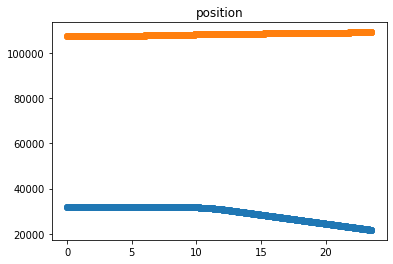

In [13]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])
plt.title("position")

Text(0.5, 1.0, 'heading and angular velocity')

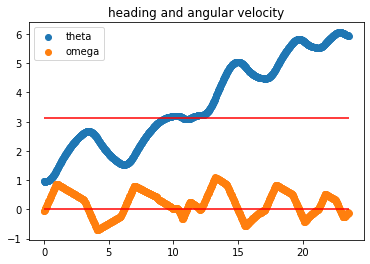

In [14]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()
plt.title("heading and angular velocity")

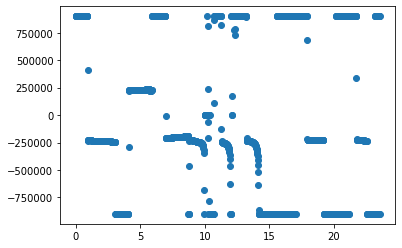

In [15]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

Text(0.5, 1.0, 'velocity')

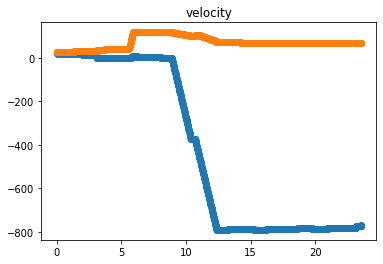

In [16]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])
plt.title("velocity")

Text(0.5, 1.0, 'acceleration')

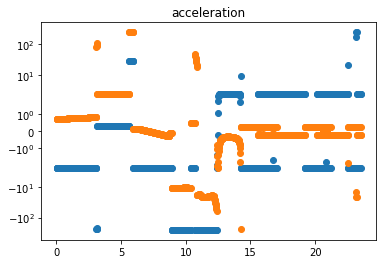

In [17]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")
plt.title("acceleration")

Text(0.5, 1.0, 'force')

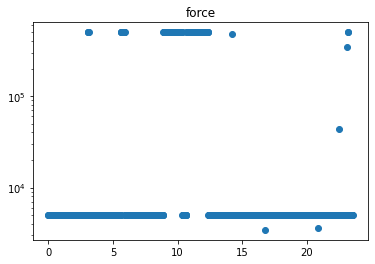

In [18]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")
plt.title("force")

# Behavior Monitoring

In [19]:
[next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in ["o.ct", "o.cs", "o.cac", "o.cbdr"]]

[0.0, None, None, None]

In [20]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()
    plt.title("status flags")
    
    flag_cols = ["o.ct", "o.cs", "o.cac", "o.cbdr"]
    first_ts = [next((df.iloc[idx]["ts"] if idx is not None else None for idx, v in zip(df.index, (~df[c].isna() & df[c] == True)) if v), None) for c in flag_cols]
    for c, ts in zip(flag_cols, first_ts):
        print(f'first {c}: {ts}')

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_collision_info(hist_length, max_time)>

### Target Location

In [21]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o.t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                o.t_dist              
                          count  min    max         min           max
o.t_loc.x   o.t_loc.y                                                
12166.39588 110026.198364  1414  0.0  23.55  9601.42839  19856.504654

In [22]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
def plot_target_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.t_dist"])
    plt.hlines(1500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(1500*0.9, sample["ts"].min(), sample["ts"].max(), color="red")
    #plt.ylim(0,1500)
    plt.title("distance to target")
    print(sample["o.t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o.t_dist"].min())

ipywidgets.interact(
    plot_target_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_target_distance(hist_length, max_time)>

(0.0, 1048.390306835178)

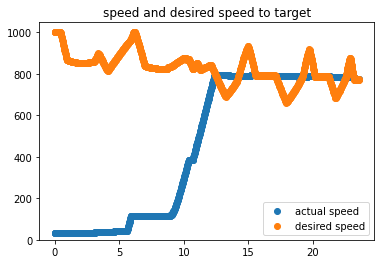

In [23]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o.t_speed"], label="desired speed")
plt.legend()
plt.title("speed and desired speed to target")
plt.ylim(0)

Text(0.5, 1.0, 'desired speed delta')

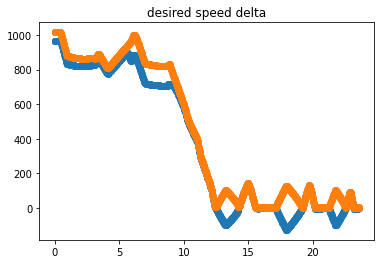

In [24]:
plt.scatter(df["ts"], df["o.t_speed"] - df["speed"])
plt.scatter(df["ts"], np.linalg.norm(np.array((df["o.t_v.x"] - df["v.x"], df["o.t_v.y"] - df["v.y"])), axis=0))
plt.title("desired speed delta")

## Collision Avoidance

In [25]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o.ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

ts                        \
                                     count        min        max   
o.ct                                                               
2772a5b5-a2ae-426c-87ae-311179dc797f   524   0.000000   8.716667   
4f96453a-5e58-4aa3-9be0-15acc0f10bd0    28  10.383333  10.833333   

                                         o.ct_dist                
                                               min           max  
o.ct                                                              
2772a5b5-a2ae-426c-87ae-311179dc797f    527.315773    791.495358  
4f96453a-5e58-4aa3-9be0-15acc0f10bd0  16912.164650  17166.429165

In [26]:
def plot_collision_distance(hist_length, max_time):
    sample = df[(df["ts"] >= max_time-hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dist"])
    plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
    plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
    plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
    plt.ylim(0)
    plt.title("distance to collision threat")
    print(sample["o.ct_dist"].min())

ipywidgets.interact(
    plot_collision_distance,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False)
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_collision_distance(hist_length, max_time)>

(0.0, 23.549999999999944)

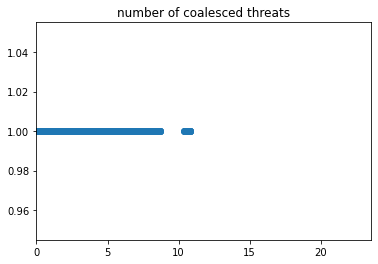

In [27]:
plt.scatter(df["ts"], df["o.ct_ct"])
plt.title("number of coalesced threats")
plt.xlim(df["ts"].min(), df["ts"].max())

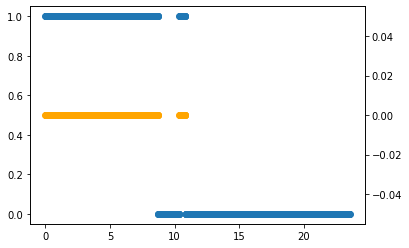

In [28]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

In [29]:
def plot_collision_dv(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], sample["o.ct_dv.x"])
    plt.scatter(sample["ts"], sample["o.ct_dv.y"])
    plt.title("collision avoidance velocity")

ipywidgets.interact(
    plot_collision_dv,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_collision_dv(hist_length, max_time)>

# History Visualization

## Position and Velocity

In [33]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o.ct_v.x"], sample["o.ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
        
        t_next = 10
        x, y = ct.iloc[-1]["o.ct_loc.x"], ct.iloc[-1]["o.ct_loc.y"]
        x_next, y_next = ct.iloc[-1]["o.ct_loc.x"]+ct.iloc[-1]["o.ct_v.x"]*t_next, ct.iloc[-1]["o.ct_loc.y"]+ct.iloc[-1]["o.ct_v.y"]*t_next
        if x_next != x or y_next != y:
            plt.axline((x,y),(x_next,y_next), marker = 'x', color=c, dashes=[2,2])
           
    cloc_df = sample[~(sample["o.ct_cloc"].isna())]
    if len(cloc_df) > 0:
        cloc_x = cloc_df.iloc[-1]["o.ct_cloc.x"]
        cloc_y = cloc_df.iloc[-1]["o.ct_cloc.y"]
        cradius = cloc_df.iloc[-1]["o.ct_cradius"]
        threat_radius = plt.Circle((cloc_x, cloc_y), cradius, color="red", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500, color="orange", fill=False)
        margin = plt.Circle((cloc_x, cloc_y), cradius+30+500*2, color="green", fill=False)
        plt.gca().add_patch(threat_radius)
        plt.gca().add_patch(margin)
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1500, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 1500*0.9, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
            
    t_next = 10
    x, y = sample.iloc[-1]["loc.x"], sample.iloc[-1]["loc.y"]
    x_next, y_next = sample.iloc[-1]["loc.x"]+sample.iloc[-1]["v.x"]*t_next, sample.iloc[-1]["loc.y"]+sample.iloc[-1]["v.y"]*t_next
    if x_next != x or y_next != y:
        plt.axline((x,y),(x_next,y_next),marker = 'o')
    
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max()+1/60, min=df["ts"].min(), max=df["ts"].max()+1/60, continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_collision_chart(hist_length=23.549999999999944, max_time=23.549999999999944, sampling_interval=50, show_tloc=True)>

## Position and Heading

In [31]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::10]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)
    
    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=23.549999…

<function __main__.plot_collision_chart(hist_length=23.549999999999944, max_time=23.549999999999944)>

# 